In [4]:
import torch
from torch import optim, nn, tensor
import torch.nn.functional as F

from utils import with_cbs, inplace, to_device, MetricsCB, DeviceCB, ProgressCB, set_seed

from datasets import load_dataset, load_dataset_builder

import torchvision.transforms.functional as TF

from torcheval.metrics import MulticlassAccuracy, Mean

import logging

import matplotlib.pyplot as plt

from functools import partial

from dataloaders import DataLoaders

from learners import TrainLearner

In [2]:
dsd = load_dataset('fashion_mnist')
bs = 1024
x,y = 'image', 'label'

@inplace
def transformi(b):
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

tds = dsd.with_transform(transformi)

In [5]:
dls = DataLoaders.from_dd(tds, bs)

m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

cbs = [DeviceCB(device='cpu'), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True)]
model = get_model()

learner = TrainLearner(model, dls, loss_func=F.cross_entropy, lr=0.2, opt_func=optim.SGD, cbs=cbs)
learner.fit(5)

NameError: name 'run_cbs' is not defined

## Activations

In [6]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: 
        res = nn.Sequential(res, nn.ReLU())

    return res

def cnn_layers():
    return [
        conv(1, 8, ks=5),           # 14x14
        conv(8, 16),                # 7x7
        conv(16, 32),               # 4x4
        conv(32, 64),               # 2x2
        conv(64, 10, act=False),    # 1x1
        nn.Flatten()
    ]

def fit(model, epochs=1, xtra_cbs=[]):
    learn = TrainLearner(model, dls, loss_func=F.cross_entropy, lr=0.2, cbs=cbs+list(xtra_cbs))
    learn.fit(epochs)


x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

set_seed(1)
fit(nn.Sequential(*cnn_layers()))

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1024, 784]

accuracy,loss,epoch,train
0.207,2.201,0,train
0.566,1.259,0,eval


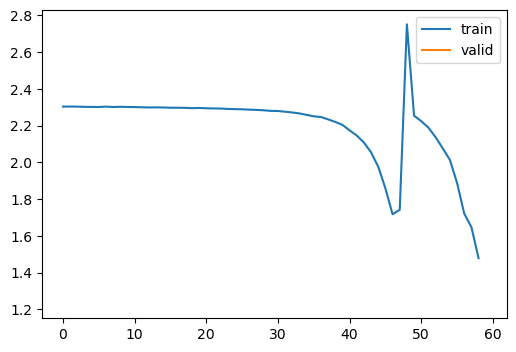

In [32]:
class SequentialModel(nn.Module):

    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]

    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.detach().mean())
            self.act_stds[i].append(x.detach().std())
        return x

    def __iter__(self): return iter(self.layers)

set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

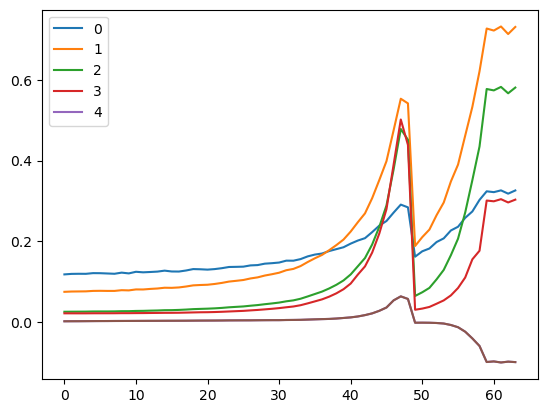

In [35]:
for l in model.act_means: 
    plt.plot(l)

plt.legend(range(5))

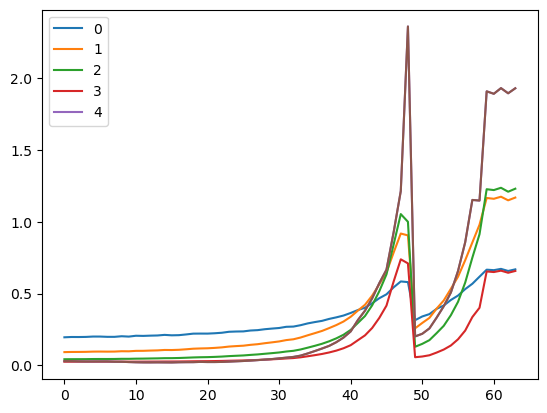

In [36]:
for l in model.act_stds: 
    plt.plot(l)

plt.legend(range(5))

## Pytorch Hooks

accuracy,loss,epoch,train
0.584,1.163,0,train
0.671,0.932,0,eval


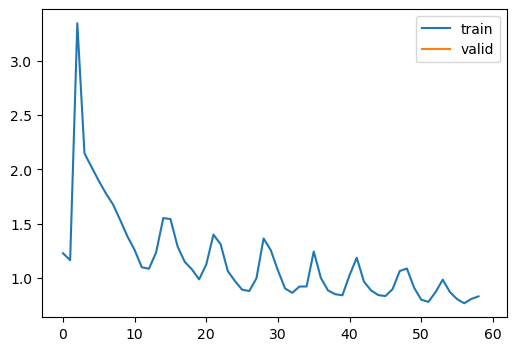

In [44]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

def set_stats(i, mod, inp, outp):
    act_means[i].append(outp.detach().mean())
    act_stds[i].append(outp.detach().std())

for i,m in enumerate(model): m.register_forward_hook(partial(set_stats, i))

fit(model)

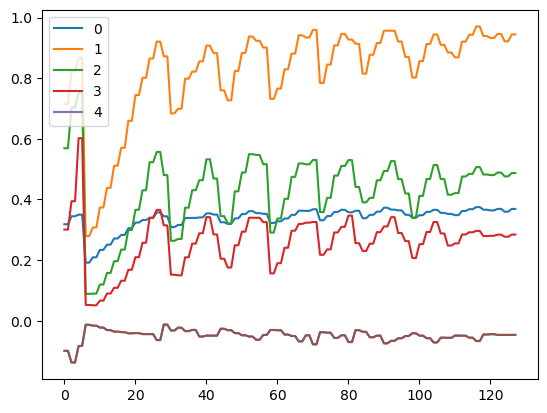

In [45]:
for o in act_means: plt.plot(o)
plt.legend(range(5))

In [62]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    acts = outp.detach()
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[1].append(acts.abs().histc(40, 0, 10))

class Hook:

    def __init__(self, m, f):
        self.hook = m.register_forward_hook(partial(f, self))

    def __del__(self):
        self.remove()

    def remove(self):
        self.hook.remove()


class Hooks(list):
    def __init__(self, ms, f):
        super().__init__([Hook(m, f) for m in ms])

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
        self.remove()

    def __del__(self):
        self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)

    def remove(self):
        for h in self:
            h.remove()

class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()

    def before_fit(self, learn):
        if self.mods: mods = self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training):
            self.hookfunc(*args, **kwargs)

    def after_fit(self, learn):
        self.hooks.remove()

    def __iter__(self):
        return iter(self.hooks)

    def __len__(self):
        return len(self.hooks)

accuracy,loss,epoch,train
0.207,2.201,0,train
0.566,1.259,0,eval


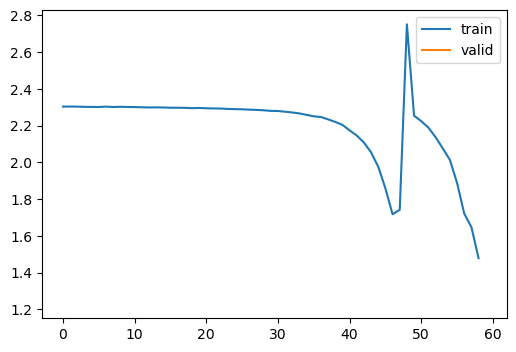

In [63]:

hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
     

set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc])

In [65]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

NameError: name 'get_grid' is not defined

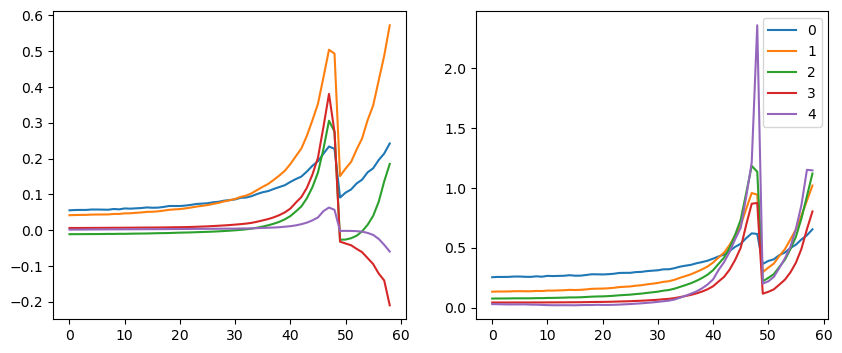

In [61]:

fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6))

In [6]:
@inplace
def transformi(b): 
    b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

# xb,yb = next(iter(dls.train))
# xb.mean(),xb.std()